
<center>
    <h1>Blai Ras Jimenez</h1>
</center>

# Ethical Data Science
    
## Assignment: Risk predicition of criminal re-offense



**This notebook** presents an exploration of a sub-set of data from **[SAVRY](https://www.parinc.com/Products/Pkey/390)** (Structured Assessment of Violence Risk in Youth) applied to young offenders in Catalonia. 

SAVRY is a risk assessment tool, that supports structured professional judgement. SAVRY contains 24 risk factors, in which each item (variables `V65*` to `V88*`) can have one of three values (low=0, moderate=1, high=2), for a total score between 0 and 48 points. 

+ Human score: There is also a score by a professional (variable `V56_@R1_resum_risc_global_reverse`) that can be low, moderate, or high. 
+ Recividism: In this dataset, there is information about whether people committed a new crime after the evaluation.  The variable `V115_reincidencia_2015` represents Recidivism (year 2015).
+ The variable `V60_SAVRY_total_score` contains a sum of scores in the risk items of SAVRY. This score can be seen as a baseline automatic method.

Features values can be found in ``reincidenciaJusticiaMenors.xlsx``. The description of features can be found in ``recidivismJuvenileJustice_variables_EN.pdf``. The data file we use is a subset of data obtained by the Centre d'Estudis Jurídics i Formació Especialitzada of the Catalan government and released in 2017.

The objectives of this assignment are: 
+ To compare the performance of SAVRY and ML-based methods, in terms of both performace and fairness metrics. 
+ To analyze the causes of unfairness.
+ To explore a mitigation strategy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, roc_curve, auc

### Data Exploration

In [2]:
FILENAME_DATASET = 'reincidenciaJusticiaMenors.xlsx'

df = pd.read_excel(FILENAME_DATASET)
df.head()

,id,V1_sexe,V2_estranger,V3_nacionalitat,V4_nacionalitat_agrupat,V5_edat_fet_agrupat,V6_provincia,V7_comarca,V8_edat_fet,V9_edat_final_programa,...,V123_rein_fet_agrupat_2013,V124_rein_fet_violencia_2013,V125_rein_fet_tipus_2013,V126_primera_reincidencia_2013,V127_rein_programa_2013,V128_rein_programa_agrupat_2013,V129_on_reincidencia_2013,V130_nombre_rein_agrupat_2013,V131_severitat_puntuacio_2013,V132_REINCIDENCIA_2013
0,691,Home,Espanyol,Espanya,NaN,14 i 15 anys,Lleida,Segrià,15.0,17,...,Contra la propietat no violent,No violent,Delicte,Presó,SIPC - Preventiva,Presó,Només Presó,2 o 3 reincidències,2.0,Sí
1,956,Dona,Espanyol,Espanya,NaN,14 i 15 anys,Barcelona,Barcelonès,14.0,15,...,Contra la propietat no violent,No violent,Delicte,Justícia juvenil,Assessorament tècnic menors,ATM,Només JJ,2 o 3 reincidències,1.0,Sí
2,2560,Home,Estranger,Marroc,Magrib,14 i 15 anys,Barcelona,Anoia,15.0,16,...,Altres,No violent,Delicte,Justícia juvenil,Realització de tasques socioeducatives,Altres MO,Justícia juvenil i presó,Més de 3 reincidències,2.0,Sí
3,2018,Home,Estranger,Marroc,Magrib,14 i 15 anys,Girona,Gironès,14.0,15,...,Altres,No violent,Delicte,Justícia juvenil,Permanència de cap de setmana en centre,Internament,Només JJ,Més de 3 reincidències,3.0,Sí
4,1650,Home,Espanyol,Espanya,NaN,16 i 17 anys,Tarragona,Tarragonès,17.0,20,...,Altres,No violent,Delicte,MPA,MPA - Treballs en benefici de la comunitat,TBC,Només MPA,1 reincidència,1.0,Sí


In [3]:
for k,i in enumerate(list(df.columns)):
    print(k,i)

0 id
1 V1_sexe
2 V2_estranger
3 V3_nacionalitat
4 V4_nacionalitat_agrupat
5 V5_edat_fet_agrupat
6 V6_provincia
7 V7_comarca
8 V8_edat_fet
9 V9_edat_final_programa
10 V10_data_naixement
11 xxxxxxxx_FETS
12 V11_antecedents
13 V12_nombre_ante_agrupat
14 V13_nombre_fets_agrupat
15 V14_fet
16 V15_fet_agrupat
17 V16_fet_violencia
18 V17_fet_tipus
19 V19_fets_desagrupats
20 V20_nombre_antecedents
21 V21_fet_nombre
22 V22_data_fet
23 xxxxxxxx_PROGRAMA
24 V23_territori
25 V24_programa
26 V25_programa_mesura
27 V26_mesures
28 V27_durada_programa_agrupat
29 V28_temps_inici
30 V29_durada_programa
31 V30_data_inici_programa
32 V31_data_fi_programa
33 xxxxxxxxxxxxxx_MRM
34 V32_MRM_resultat
35 V33_MRM_participacio_victima
36 V34_MRM_tipus
37 V35_MRM_forma
38 V36_MRM_negatiu
39 V37_MRM_conciliacio_victimaexlus
40 V38_MRM_reparacio_economica
41 V39_MRM_reparacio_noeconomica
42 V40_MRM_reparacio_comunitaria
43 V41_MRM_participacio_trobada
44 V42_MRM_participacio_notrobada
45 V43_MRM_iniciativa_parts
46 

In [4]:
# data cleaning

df = df.dropna(subset=["V60_SAVRY_total_score", 
                       "V8_edat_fet", 
                       "V20_nombre_antecedents", 
                       "V89_@P1_impicacio_prosocial", 
                       "V90_@P2_suport_social_fort",
                       "V91_@P3_forta_vinculacio_adult_prosocial", 
                       "V92_@P4_actitud_positiva_intervencions_autoritat",
                       "V93_@P5_fort_compromis_escola_treball", 
                       "V94_@P6_perseverança_tret_personalitat"])
df = df.drop(df[df["V60_SAVRY_total_score"]>48].index)

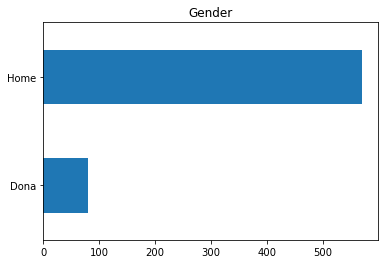

In [5]:
# data distribution by gender

_ = df['V1_sexe'].value_counts(ascending=True).plot(kind='barh', title='Gender')

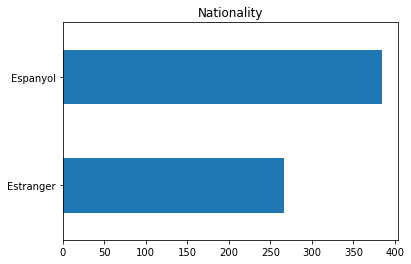

In [6]:
# data distribution by nationality

_ = df['V2_estranger'].value_counts(ascending=True).plot(kind='barh', title='Nationality')

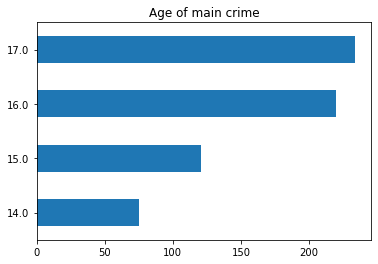

In [7]:
# data distribution by age

_ = df['V8_edat_fet'].value_counts(ascending=True).plot(kind='barh', title='Age of main crime')

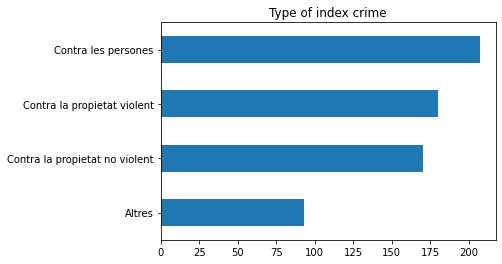

In [8]:
# data distribution by type of index crime

_ = df['V15_fet_agrupat'].value_counts(ascending=True).plot(kind='barh', title='Type of index crime')

## SAVRY model (human assessment)

The column `V56_@R1_resum_risc_global_reverse` is an evaluation done by a professional expert (that can be low, moderate, or high), based on the results of SAVRY but **applying his/her own judgment independently of the obtained score**.

The expert rates each defendant as "low", "medium", or "high" risk. Ideally, defendants considered low risk should recidivate at a lower rate than defendants considered high risk.

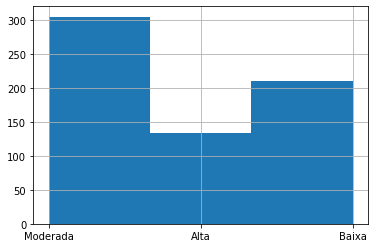

In [9]:
# human score distribution

hist = df['V56_@R1_resum_risc_global_reverse'].hist(bins=3)

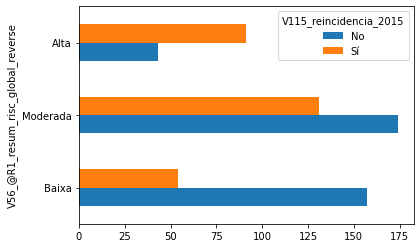

In [10]:
# human score distribution | recividism

human_ctable = pd.crosstab(df['V56_@R1_resum_risc_global_reverse'], df['V115_reincidencia_2015'])
human_ctable = human_ctable.reindex(index=["Baixa", "Moderada", "Alta"])
_ = human_ctable.plot(kind='barh')

In [11]:
# recividism rate per score

human_ctable["recidivism_rate"] = pd.Series(index=human_ctable.index, dtype='float')
for index, row in human_ctable.iterrows():
    recidivism_rate =row["Sí"] / (row["Sí"] + row["No"])
    human_ctable.at[index, "recidivism_rate"] = recidivism_rate
    
human_ctable

V115_reincidencia_2015,No,Sí,recidivism_rate
V56_@R1_resum_risc_global_reverse,,,
Baixa,157,54,0.255924
Moderada,174,131,0.429508
Alta,43,91,0.679104


### Baseline model

Our baseline prediction can be based on the column `V60_SAVRY_total_score`, which contains a sum of scores in the risk items of SAVRY. The max value of this sum is 40.

In [12]:
scores_recidivists = df[df["V115_reincidencia_2015"]=='Sí']["V60_SAVRY_total_score"].values
scores_non_recidivists = df[df["V115_reincidencia_2015"]=='No']["V60_SAVRY_total_score"].values

In [13]:
def compare_histograms(scores1, scores2, title, label1='Recidivists', label2='Non recidivists'):
    plt.figure(figsize=(10,6))
    plt.hist(scores1, histtype='step', label=label1, density=True, color='red')
    plt.hist(scores2, histtype='step', label=label2, density=True, color='blue')
    plt.legend(loc='upper right', fontsize='x-large')
    plt.ylabel('Probability')
    plt.xlabel(title)
    plt.show()

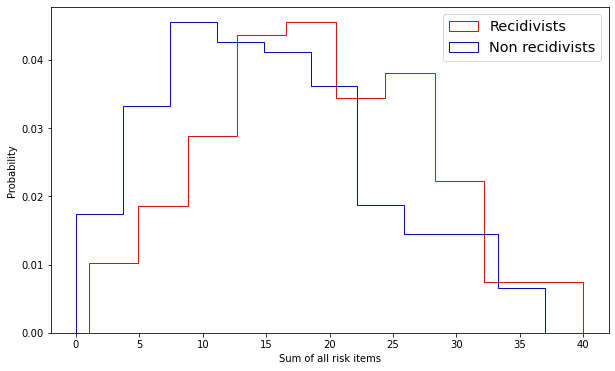

In [14]:
## baselin score distribution

compare_histograms(scores_recidivists, scores_non_recidivists, 'Sum of all risk items')

In [15]:
def draw_roc_curve( ground_truth, predictions, pos_label="Sí"):
    fpr, tpr, thresholds = roc_curve(ground_truth, predictions, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10,6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right", fontsize='x-large')
    plt.show()
    return roc_auc

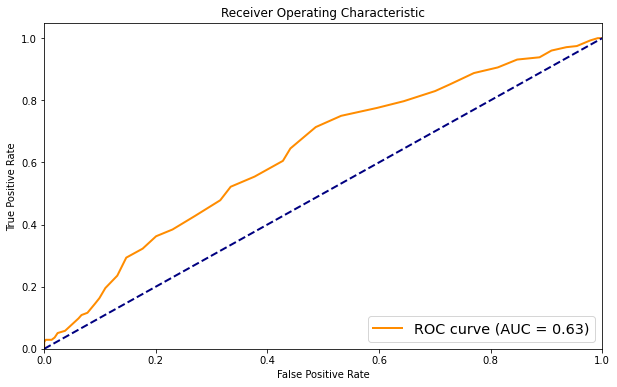

In [16]:
# Evaluation (ROC curve) of the baseline prediction

_ = draw_roc_curve(df["V115_reincidencia_2015"].values, df["V60_SAVRY_total_score"].values)

## Modeling recidivism using logistic regression

Logistic regression is a simple yet effective classification model for this problem.

In all cases above we will use the same training/testing split, which is done randomly, keeping 1/3 of the data for testing. You can repeat the following cells a couple of times to see how a different train/test split changes the AUC.

In [17]:
train, test = train_test_split(df, test_size=0.33,random_state=1997)

### Modeling recidivism (24 risk factors)

Now we model recidivism by using the 24 risk factors in SAVRY.

Note that the performance depends on the training/testing split which is done randomly, keeping 1/3 of the data for testing. Repeat the following cells a couple of times to see how a different train/test split changes the AUC.

In [18]:
risk_factor_columns = list(df.columns)[70:94]

train_X = pd.get_dummies(train[risk_factor_columns])
train_y = train["V115_reincidencia_2015"]

test_X = pd.get_dummies(test[risk_factor_columns])
test_y = test["V115_reincidencia_2015"]

In [19]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [20]:
pred24_y = model.predict_proba(test_X)[:,1]
pred24_recidivists = pred24_y[test_y == 'Sí']
pred24_non_recidivists = pred24_y[test_y == 'No']

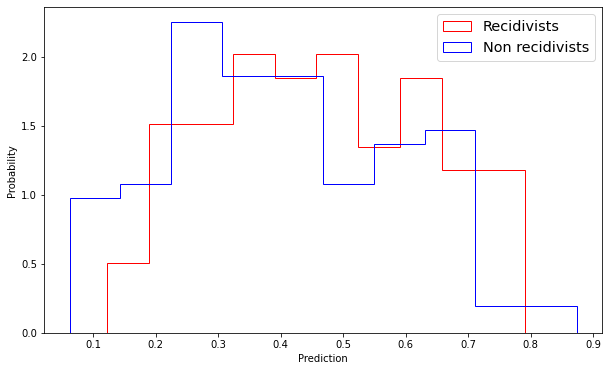

In [21]:
compare_histograms(pred24_recidivists, pred24_non_recidivists, 'Prediction')

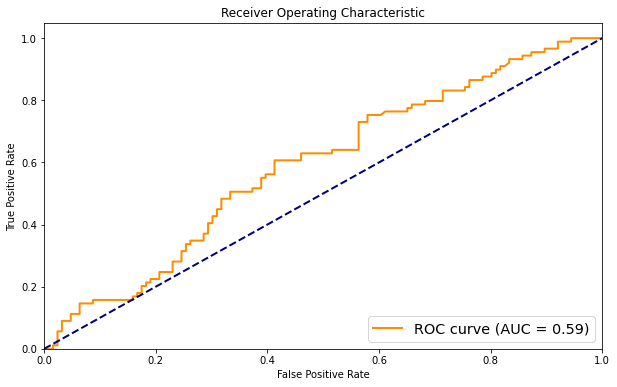

In [22]:
_ = draw_roc_curve(test_y, pred24_y)

### Modeling recidivism (personal history factors)

Next we use demographic factors: gender and nationality, as well as criminal history factors such as the age of commission of the index crime and its type, as well as whether the juvenile defendant has criminal records.

In [23]:
demographic_columns = ["V1_sexe", 
                       "V2_estranger", 
                       "V8_edat_fet", 
                       "V20_nombre_antecedents",
                       "V15_fet_agrupat", 
                       "V16_fet_violencia"]
                       
train_X = pd.get_dummies(train[demographic_columns])
train_y = train["V115_reincidencia_2015"]

test_X =  pd.get_dummies(test[demographic_columns])
test_y = test["V115_reincidencia_2015"]

In [24]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [25]:
predPH_y = model.predict_proba(test_X)[:,1]
predPH_recidivists = predPH_y[test_y == 'Sí']
predPH_non_recidivists = predPH_y[test_y == 'No']

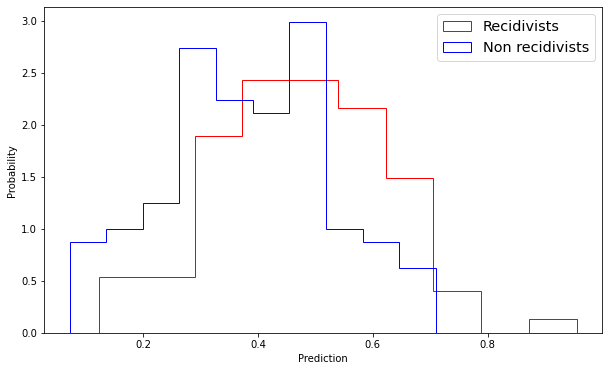

In [26]:
compare_histograms(predPH_recidivists, predPH_non_recidivists, 'Prediction')

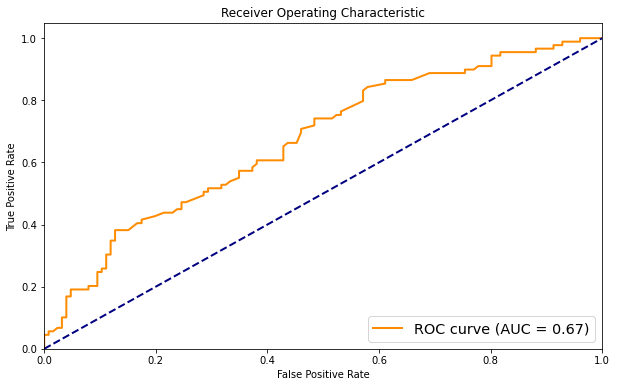

In [27]:
_ = draw_roc_curve(test_y, predPH_y)

### Modeling recidivism (personal history + 24 risk factors + 6 protective factors)

We now add to the above 6 "protective" or positive factors that are associated with a low risk.

In [28]:
protective_factor_columns = ["V89_@P1_impicacio_prosocial", 
                             "V90_@P2_suport_social_fort",
                             "V91_@P3_forta_vinculacio_adult_prosocial", 
                             "V92_@P4_actitud_positiva_intervencions_autoritat",
                             "V93_@P5_fort_compromis_escola_treball", 
                             "V94_@P6_perseverança_tret_personalitat"]

factors = demographic_columns + risk_factor_columns + protective_factor_columns

train_X = pd.get_dummies(train[factors])
train_y = train["V115_reincidencia_2015"]

test_X = pd.get_dummies(test[factors])
test_y = test["V115_reincidencia_2015"]

In [29]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [30]:
predALL_y = model.predict_proba(test_X)[:,1]
predALL_recidivists = predALL_y[test_y == 'Sí']
predALL_non_recidivists = predALL_y[test_y == 'No']

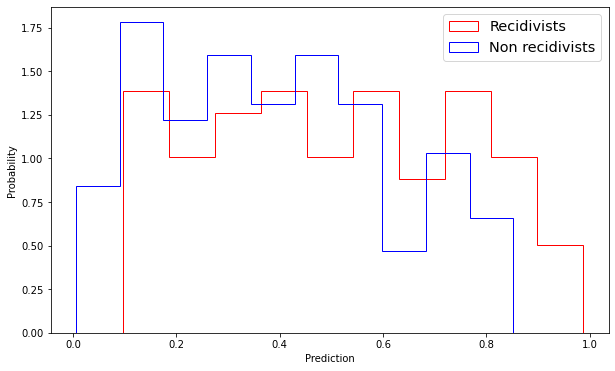

In [31]:
compare_histograms(predALL_recidivists, predALL_non_recidivists, 'Prediction')

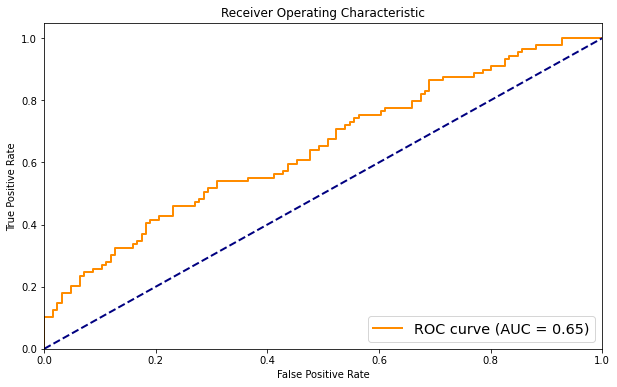

In [32]:
_ = draw_roc_curve(test_y, predALL_y)

# Recidivism and fairness
We remark that fairness is not necessarily that people in different groups obtain the same outcomes. For instance, in this dataset, women recidivate at about half the rate as men, and foreigners at a higher rate than nationals.

In [33]:
recidivism_by_gender = pd.crosstab(df["V115_reincidencia_2015"], df["V1_sexe"])
recidivism_by_gender['Dona'] = recidivism_by_gender['Dona'] / recidivism_by_gender['Dona'].sum()
recidivism_by_gender['Home'] = recidivism_by_gender['Home'] / recidivism_by_gender['Home'].sum()
recidivism_by_gender

V1_sexe,Dona,Home
V115_reincidencia_2015,,
No,0.759494,0.549912
Sí,0.240506,0.450088


In [34]:
recidivism_by_nationality = pd.crosstab(df["V115_reincidencia_2015"], df["V2_estranger"])
recidivism_by_nationality['Espanyol'] = recidivism_by_nationality['Espanyol'] / recidivism_by_nationality['Espanyol'].sum()
recidivism_by_nationality['Estranger'] = recidivism_by_nationality['Estranger'] / recidivism_by_nationality['Estranger'].sum()
recidivism_by_nationality

V2_estranger,Espanyol,Estranger
V115_reincidencia_2015,,
No,0.632812,0.492481
Sí,0.367188,0.507519


# Fairness as **equality of error rates**

We can look at fairness as **equality of error rates**.

## Professional (human expert) recidivism prediction and fairness

We consider people who did not recidivate, in particular, look at those who were given a "high" risk by the expert.

In [35]:
non_recidivists = df[df["V115_reincidencia_2015"] == 'No']
non_recidivists_expert_by_gender = pd.crosstab(non_recidivists["V56_@R1_resum_risc_global_reverse"], non_recidivists["V1_sexe"])
non_recidivists_expert_by_gender.reindex(index=["Baix", "Moderat", "Alt"])
non_recidivists_expert_by_gender["Home"] = non_recidivists_expert_by_gender["Home"] / non_recidivists_expert_by_gender["Home"].sum()
non_recidivists_expert_by_gender["Dona"] = non_recidivists_expert_by_gender["Dona"] / non_recidivists_expert_by_gender["Dona"].sum()
non_recidivists_expert_by_gender

V1_sexe,Dona,Home
V56_@R1_resum_risc_global_reverse,,
Alta,0.116667,0.114650
Baixa,0.433333,0.417197
Moderada,0.450000,0.468153


In [36]:
non_recidivists_expert_by_nationality = pd.crosstab(non_recidivists["V56_@R1_resum_risc_global_reverse"], non_recidivists["V2_estranger"])
non_recidivists_expert_by_nationality.reindex(index=["Baix", "Moderat", "Alt"])
non_recidivists_expert_by_nationality["Espanyol"] = non_recidivists_expert_by_nationality["Espanyol"] / non_recidivists_expert_by_nationality["Espanyol"].sum()
non_recidivists_expert_by_nationality["Estranger"] = non_recidivists_expert_by_nationality["Estranger"] / non_recidivists_expert_by_nationality["Estranger"].sum()
non_recidivists_expert_by_nationality

V2_estranger,Espanyol,Estranger
V56_@R1_resum_risc_global_reverse,,
Alta,0.106996,0.129771
Baixa,0.423868,0.412214
Moderada,0.469136,0.458015


## Overall SAVRY score and fairness

In [37]:
scores_men_non_recidivists = df[(df["V115_reincidencia_2015"]=='Sí') &
                                      (df["V1_sexe"]=='Home')]["V60_SAVRY_total_score"].values
scores_women_non_recidivists = df[(df["V115_reincidencia_2015"]=='No') &
                                       (df["V1_sexe"]=='Dona')]["V60_SAVRY_total_score"].values

print("Average SAVRY score of men non-recidivist: %.2f" %
      (scores_men_non_recidivists.sum() / len(scores_men_non_recidivists)))
       
print("Average SAVRY score of women non-recidivist: %.2f" % 
      (scores_women_non_recidivists.sum() / len(scores_women_non_recidivists)))

Average SAVRY score of men non-recidivist: 19.12
Average SAVRY score of women non-recidivist: 15.67


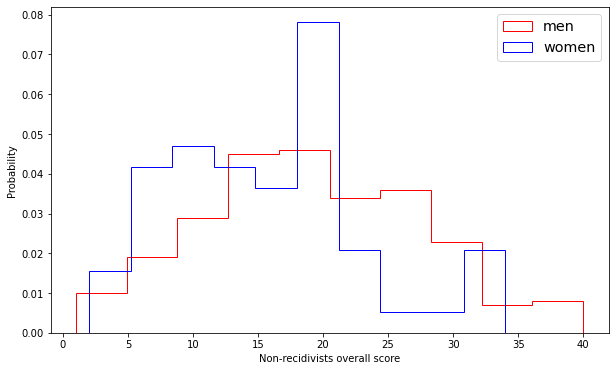

In [38]:
compare_histograms(scores_men_non_recidivists, scores_women_non_recidivists,
                   "Non-recidivists overall score",
                   label1="men", label2="women")

In [39]:
scores_nationals_non_recidivists = df[(df["V115_reincidencia_2015"]=='Sí') &
                                      (df["V2_estranger"]=='Espanyol')]["V60_SAVRY_total_score"].values
scores_foreigners_non_recidivists = df[(df["V115_reincidencia_2015"]=='No') &
                                       (df["V2_estranger"]=='Estranger')]["V60_SAVRY_total_score"].values

print("Average SAVRY score of national non-recidivist: %.2f" %
      (scores_nationals_non_recidivists.sum() / len(scores_nationals_non_recidivists)))
       
print("Average SAVRY score of foreigner non-recidivist: %.2f" % 
      (scores_foreigners_non_recidivists.sum() / len(scores_foreigners_non_recidivists)))

Average SAVRY score of national non-recidivist: 18.89
Average SAVRY score of foreigner non-recidivist: 16.51


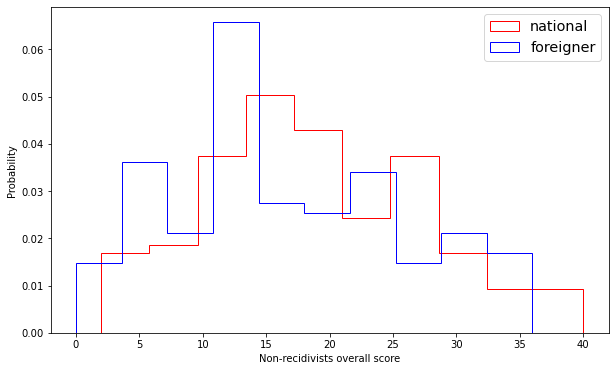

In [40]:
compare_histograms(scores_nationals_non_recidivists, scores_foreigners_non_recidivists,
                   "Non-recidivists overall score",
                   label1="national", label2="foreigner")

## Fairness using ML score

In [41]:
predPH_men_non_recidivists = predPH_y[(test_y=='No') & (test_X["V1_sexe_Home"]==1)]
predPH_women_non_recidivists = predPH_y[(test_y=='No') & (test_X["V1_sexe_Dona"]==1)]

print("Average predicted probability of men non-recidivist: %.2f" %
      (predPH_men_non_recidivists.sum() / len(predPH_men_non_recidivists)))
       
print("Average predicted probability of women non-recidivist: %.2f" % 
      (predPH_women_non_recidivists.sum() / len(predPH_women_non_recidivists)))

Average predicted probability of men non-recidivist: 0.43
Average predicted probability of women non-recidivist: 0.17


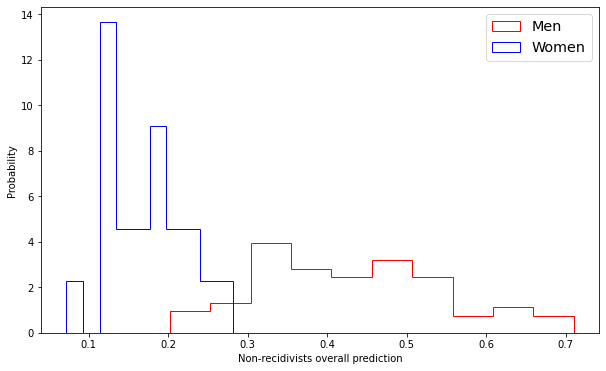

In [42]:
compare_histograms(predPH_men_non_recidivists, predPH_women_non_recidivists,
                   "Non-recidivists overall prediction",
                   label1="Men", label2="Women")

In [43]:
predPH_nationals_non_recidivists = predPH_y[(test_y=='No') & (test_X["V2_estranger_Espanyol"]==1)]
predPH_foreigners_non_recidivists = predPH_y[(test_y=='No') & (test_X["V2_estranger_Estranger"]==1)]

print("Average predicted probability of national non-recidivist: %.2f" %
      (predPH_nationals_non_recidivists.sum() / len(predPH_nationals_non_recidivists)))
       
print("Average predicted probability of foreigner non-recidivist: %.2f" % 
      (predPH_foreigners_non_recidivists.sum() / len(predPH_foreigners_non_recidivists)))

Average predicted probability of national non-recidivist: 0.34
Average predicted probability of foreigner non-recidivist: 0.48


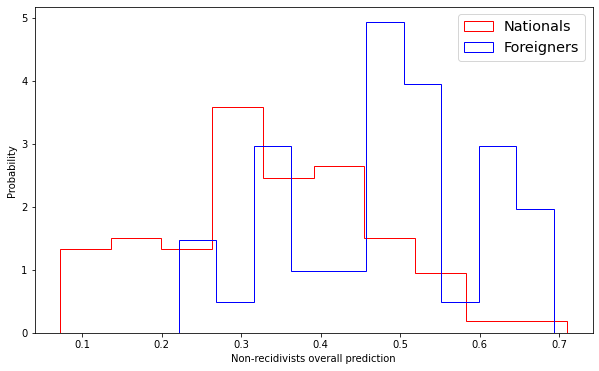

In [44]:
compare_histograms(predPH_nationals_non_recidivists, predPH_foreigners_non_recidivists,
                   "Non-recidivists overall prediction",
                   label1="Nationals", label2="Foreigners")

# Exercise 1

1. Use different machine learning models (SVM, Random Forests, etc.) to check if you can increase the performance of the logistic regression model. 




In [36]:
#Model's import
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

#Training architecture, Cross-Validation
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
#Standardization
from sklearn import preprocessing
from sklearn.preprocessing  import StandardScaler, RobustScaler
#Model save/laod
import pickle
#Utils
import time
import random

I decided to set up a model cross-validation grid search training with a **pipeline of 5 models**:

* MLP: Multi-Layer Perceptron, a Neural Network classification model.
* RF: Random Forest
* GB: Gradient Boosting classifier
* SVM: Support-Vector Machine classifier
* Tree: Decision Tree Classifier

Each of them uses a `RobustScaler()` for scaling the input features values. I also tried the ``StandardScaler()``, but the results were worse. 

In [37]:
# Pipeline dictionary
pipelines = {
    'MLP': make_pipeline(RobustScaler(), MLPClassifier(max_iter=500,random_state=1997,
                                                                       early_stopping=True,n_iter_no_change=5)),
    'RF': make_pipeline(RobustScaler(),RandomForestClassifier(random_state=1997)),
    'GB': make_pipeline(RobustScaler(),GradientBoostingClassifier(random_state=1997)),
    'SVM': make_pipeline(RobustScaler(), SVC(random_state=1997,probability=True)),
    'Tree': make_pipeline(RobustScaler(), DecisionTreeClassifier(random_state=1997))
}

Below we have the **hyperparameter set-up for each model**. I've tested some more hyperparameters, but the final configuration that we have below is the most adequate. 

In [38]:
# MLP hyperparameters
MLP_hyperparameters = {
    'mlpclassifier__activation': ['relu','tanh',"logistic"],
    'mlpclassifier__solver':['adam',"lbfgs"],
    'mlpclassifier__hidden_layer_sizes': [(200,200,200,200,200,200),(150,150,150,150,150),(120,120,120,120,120)],
    'mlpclassifier__alpha': [0.0001,0.001]
}

# Random Forest hyperparameters
rf_hyperparameters = {
    'randomforestclassifier__n_estimators': [50,100,200,250],
    'randomforestclassifier__max_features': ['auto'],
    'randomforestclassifier__max_depth':[1,5,10],
    'randomforestclassifier__min_samples_leaf': [4,5,10],
    'randomforestclassifier__min_samples_split': [10,15,20],
    'randomforestclassifier__bootstrap': [True, False]
}

# Boosted Tree hyperparameters
gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators': [1,2,50,100,200],
    'gradientboostingclassifier__learning_rate': [0.05,0.1,0.2],
    'gradientboostingclassifier__max_depth':[1.,3,5,20.,30.],
    'gradientboostingclassifier__min_samples_split':[0.1,0.5,1.],
    'gradientboostingclassifier__min_samples_leaf':[0.1,0.5],
    'gradientboostingclassifier__max_features':[1,10,40,100]
}

# SVM hyperparameters
svm_hyperparameters = {'svc__C': [0.1, 1, 10], 
          'svc__gamma': [1, 0.1, 0.01,"auto"],
          'svc__kernel': ['rbf']}

# Decision tree hyperparameters
tree_hyperparameters = {'decisiontreeclassifier__min_samples_leaf':[5,10,15,20],
                        'decisiontreeclassifier__max_features':[5,10,15],
                        'decisiontreeclassifier__criterion': ['gini', 'entropy'],
                        'decisiontreeclassifier__max_depth':[2,4,6,8,10,12]}

# Create hyperparameters dictionary
hyperparameters = {'MLP': MLP_hyperparameters,
                  'RF': rf_hyperparameters,
                  'GB': gb_hyperparameters,
                  'SVM':svm_hyperparameters,
                  'Tree':tree_hyperparameters}

Below we have the fit set-up with a Cross-Validation of 3. The metric used is the Area Under the ROC Curve.

I save each model inside ``fitted_models``. I print the best parameter configuration as well as the time taken: **~1.5 minutes.**

_Optional_

In the following cell you can **load the resulting two best models** stored into pickles:

In [39]:
# with open("RF-Ex1.pkl", "rb") as input_file:
#     RF = pickle.load(input_file)
    
# with open("SVM-Ex1.pkl", "rb") as input_file:
#     SVM = pickle.load(input_file)

In [40]:
def fit(pipelines,hyperparameters,train_X,train_y):
# Create empty dictionary called fitted_models
    fitted_models = {}
    start_time = time.time()

    # Loop through model pipelines, tuning each one and saving it to fitted_models
    for name, pipeline in pipelines.items():
        # Create cross-validation object from pipeline and hyperparameters
        model = GridSearchCV(pipeline, hyperparameters[name], cv=3, n_jobs=-1, scoring='roc_auc')

        # Fit model on X_train, y_train
        model.fit(train_X, train_y)

        # Store model in fitted_models[name] 
        fitted_models[name] = model

        # Print '{name} has been fitted'
        print('\n{0} has been fitted'.format(name))
        print("\tBest model param:",model.best_params_)

    print("\nTime:" + str((time.time() - start_time)/60))
    
    return fitted_models

In [43]:
fitted_models = fit(pipelines,hyperparameters,train_X,train_y)


MLP has been fitted
	Best model param: {'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': 0.001, 'mlpclassifier__hidden_layer_sizes': (150, 150, 150, 150, 150), 'mlpclassifier__solver': 'adam'}

RF has been fitted
	Best model param: {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 250}

GB has been fitted
	Best model param: {'gradientboostingclassifier__learning_rate': 0.2, 'gradientboostingclassifier__max_depth': 1.0, 'gradientboostingclassifier__max_features': 1, 'gradientboostingclassifier__min_samples_leaf': 0.1, 'gradientboostingclassifier__min_samples_split': 0.1, 'gradientboostingclassifier__n_estimators': 50}

SVM has been fitted
	Best model param: {'svc__C': 0.1, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}

Tree has been fitted
	Best model param: {'dec

For each one of them I print the final Mean cross-validated score of the best_estimator.

In [44]:
# Display best_score_ for each fitted model
for name,model in fitted_models.items():
    print(name, "Score: ", model.best_score_)

MLP Score:  0.6494641912347352
RF Score:  0.6503472208116118
GB Score:  0.6563698125460516
SVM Score:  0.6631225613053792
Tree Score:  0.609227939946566


Here we have the real deal: **A plot of the test predict of the ROC Curve and its AUC Score.**

MLP


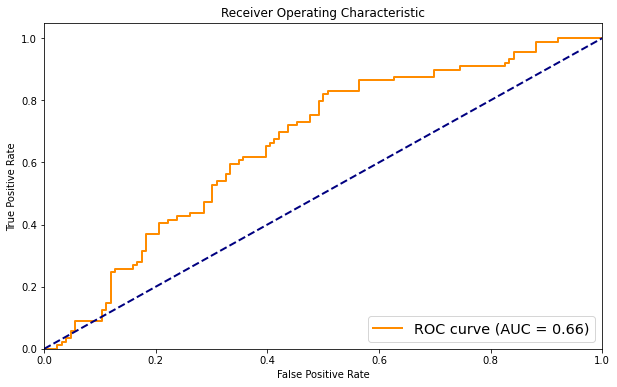

RF


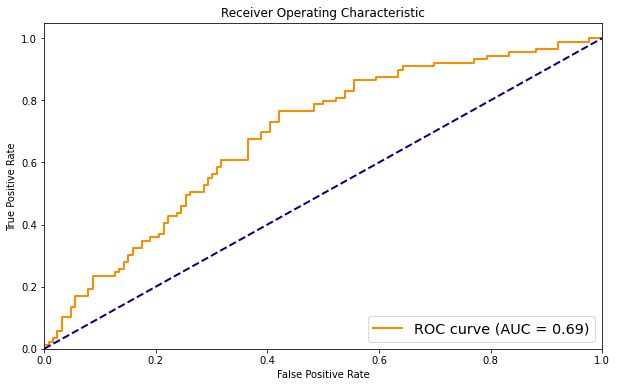

GB


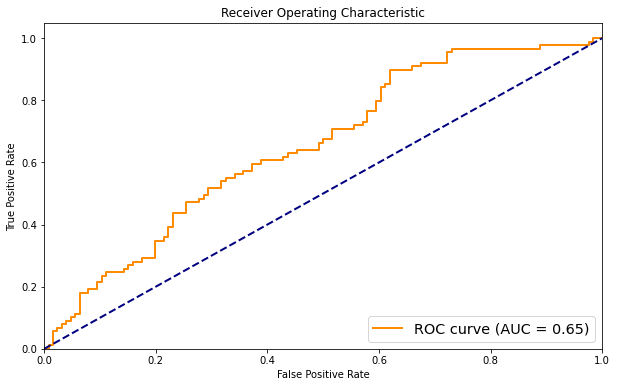

SVM


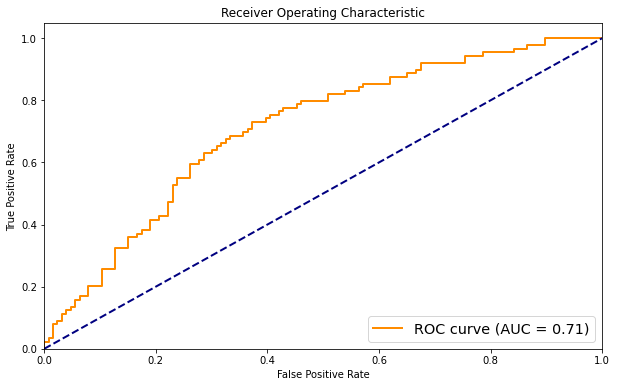

Tree


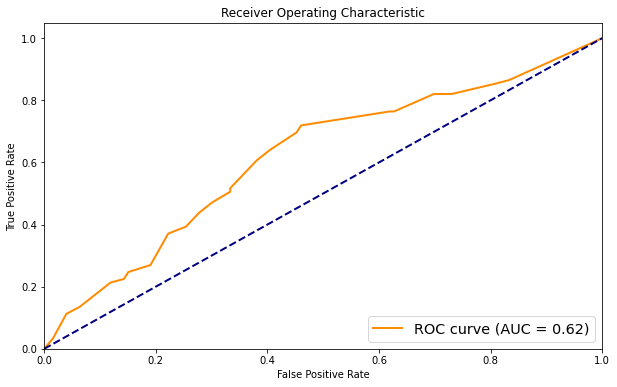

In [46]:
# print test scores
for name, model in fitted_models.items():
    print(name)
    predALL_y = model.predict_proba(test_X)[:,1]
    _ = draw_roc_curve(test_y, predALL_y)

As we can see, the best models were Random Forest and SVM, with an AUC Score respectively of 0.69 and 0.71. Let's see the **best configuration** for the highest accuracy model:

In [47]:
fitted_models["SVM"].best_params_

{'svc__C': 0.1, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}

Model saving into pickle. 

In [ ]:
with open('SVM-Ex1.pkl', 'wb') as f:
    pickle.dump(fitted_models["SVM"].best_estimator_, f)
    
with open('RF-Ex1.pkl', 'wb') as f:
    pickle.dump(fitted_models["RF"].best_estimator_, f)

2. Check if they satisfy the proposed fairness criteria. 


> In order to analyze the fairness proposed of my models I created the following code which takes each model and predicts the probability of recividism with the test set. Then, proceeds to compute the mean of probabilities with the target columns of Gender and Nationality (same code as given). 

> What's new is **the creation of a dataframe storing this probabilities for each model**. I also added two more columns: the difference between the target columns probabilities, which help me analyze the result.

In [48]:
names = []
avgMan = []
avgWom = []
avgNat = []
avgFor = []
for name, model in fitted_models.items():
    names.append(name)
    predALL_y = model.predict_proba(test_X)[:,1]
    predPH_men_non_recidivists = predALL_y[(test_y=='No') & (test_X["V1_sexe_Home"]==1)]
    predPH_women_non_recidivists = predALL_y[(test_y=='No') & (test_X["V1_sexe_Dona"]==1)]

    avgMan.append(predPH_men_non_recidivists.sum() / len(predPH_men_non_recidivists))

    avgWom.append(predPH_women_non_recidivists.sum() / len(predPH_women_non_recidivists))
    
    predPH_nationals_non_recidivists = predALL_y[(test_y=='No') & (test_X["V2_estranger_Espanyol"]==1)]
    predPH_foreigners_non_recidivists = predALL_y[(test_y=='No') & (test_X["V2_estranger_Estranger"]==1)]
    
    avgNat.append(predPH_nationals_non_recidivists.sum() / len(predPH_nationals_non_recidivists))

    avgFor.append(predPH_foreigners_non_recidivists.sum() / len(predPH_foreigners_non_recidivists))
    
modelFair =  pd.DataFrame(list(zip(names,avgMan,avgWom,avgNat,avgFor)),columns=["Model Name",
                                                                               "Avg. Prob. Man",
                                                                                "Avg. Prob. Woman",
                                                                               "Avg. Prob. National",
                                                                               "Avg. Prob. Foreigner"])

modelFair["Diff Sex"] = abs(modelFair["Avg. Prob. Man"]-modelFair["Avg. Prob. Woman"])
modelFair["Diff Origen"] = abs(modelFair["Avg. Prob. National"]-modelFair["Avg. Prob. Foreigner"])

In [49]:
modelFair.sort_values("Diff Sex",ascending=True)

,Model Name,Avg. Prob. Man,Avg. Prob. Woman,Avg. Prob. National,Avg. Prob. Foreigner,Diff Sex,Diff Origen
1,RF,0.422941,0.418952,0.419843,0.426973,0.003989,0.007130
4,Tree,0.333200,0.346322,0.321450,0.362287,0.013122,0.040837
0,MLP,0.388513,0.374579,0.384110,0.390208,0.013934,0.006098
3,SVM,0.424457,0.374124,0.395647,0.455487,0.050333,0.059840
2,GB,0.417874,0.347383,0.402518,0.413088,0.070491,0.010570


As we can see below, the model with **the most probability difference between Man and Woman** and National and Foreign people is **the model with the best AUC Score!**

Nevertheless, the Random Forest model, with a similar score as the SVM, has the less difference between this target columns. 

In conclusion, right now, with this information, I would pick the Random Forest model **taking in consideration Accuracy and Fairness.**

Therefore, from now on, I'll only work with this two models.

In [50]:
SVM = fitted_models["SVM"].best_estimator_
RF = fitted_models["RF"].best_estimator_

models = {"SVM":SVM,"RF":RF}

3. Compare several fairness criteria, such as Demographic Parity, Equal Opportunity, Equalized Odds, and Conditional Demographic Parity.

> Let me compute some known metrics for my models evaluation:

In [51]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from IPython.display import display, HTML

In [52]:
for name, model in models.items():
    
    predALL_y = model.predict_proba(test_X)[:,1]
    matrix = pd.DataFrame(confusion_matrix([1 if i == "Sí" else 0 for i in test_y], np.round(predALL_y)),columns=["Actual Positive","Actual Negative"])
    matrix.index = ["Predicted Positive","Predicted Negative"]
    f1 = f1_score([1 if i == "Sí" else 0 for i in test_y], np.round(predALL_y),average="macro")
    print("\nMODEL:",name)
    print("\tConfusion Matrix")
    display(HTML(matrix.to_html()))
    print("\tF1-Score:",f1)
    


MODEL: SVM
	Confusion Matrix


,Actual Positive,Actual Negative
Predicted Positive,97,29
Predicted Negative,44,45


	F1-Score: 0.6393694997817148

MODEL: RF
	Confusion Matrix


,Actual Positive,Actual Negative
Predicted Positive,120,6
Predicted Negative,78,11


	F1-Score: 0.4741439552760307


### SVM

The first thing I see in this model is the amount of False Negatives. 44 people were predicted as non-recividist and they actually were.

Nevertheless, we actually have a small amount of people predicted as reicividist but they actually weren't, and we have a good amount of people (97+45) predicted correctly. That's why we have a decent F1-Score: 0.63.

### RF

Here we have even few people predicted as reicividist when they actually were not, only 6. On the other hand, we have a lot more people misclassified as non-recividist and they actually were. That's why we have less F1-Score: 0.47


Now, let's switch the fairness view with the protected variables of Gender and Nationality.

## Gender

In [53]:
def build_confusion_matrix(test_X,test_y,preds):
    resultDF = pd.DataFrame()
    resultDF["Gender"] = ["Home" if i == 1 else "Dona" for i in test_X["V1_sexe_Home"]]
    resultDF["Nationality"] = ["National" if i == 1 else "Foreigner" for i in test_X["V2_estranger_Espanyol"]]
    resultDF["True"] = ["Si" if i == "Sí" else "No" for i in test_y]
    resultDF["Predict"] = ["Si" if i == 1 else "No" for i in np.round(preds)]
    return resultDF

In [54]:
for name, model in models.items():
    print("MODEL:",name)
    df = build_confusion_matrix(test_X,test_y,model.predict_proba(test_X)[:,1])
    pt = df.pivot_table(index=["Predict"], columns=["Gender","True"], aggfunc='size',fill_value=0)
    display(HTML(pt.to_html()))
print("Amount of people by gender:\n",df["Gender"].value_counts())

MODEL: SVM


MODEL: RF


Amount of people by gender:
 Home    185
Dona     30
Name: Gender, dtype: int64


### SVM

The amount of woman misclassified as recividist and they weren't is the 10%. The amount of man is the 14%. Therefore, the percentage of misclassified is more or less the same for both groups.

The amount of woman correctly classified (recividist or not) is the 76.6%. The amount of man is the 64.32%. Therefore, the percentage of correctly classified is more or less the same for both groups.

### RF

Here, there's no woman misclassified as recividist.In man, only the 3.2%, so RF wins in this category.

The problem in this model is that almost the 40% of man were incorrectly classified as non-recividist when they actually were. In woman, only the 23% percent. 

## Nationality

In [107]:
for name, model in models.items():
    print("MODEL:",name)
    df = build_confusion_matrix(test_X,test_y,model.predict_proba(test_X)[:,1])
    pt = df.pivot_table(index=["Predict"], columns=["Nationality","True"], aggfunc='size',fill_value=0)
    display(HTML(pt.to_html()))
print("Amount of people by Nationality:\n",df["Nationality"].value_counts())

MODEL: SVM


MODEL: RF


Amount of people by Nationality:
 National     130
Foreigner     85
Name: Nationality, dtype: int64


### SVM

The amount of foreigner people incorrectly classified as recividist that actually weren't is the 17.64%. The amount of national people is the 10%. That's almost 8 points of difference so we can think of a possible presence of discrimination in this model against foreign people.

On the other hand, almost the same percentage of national and foreign poeple were correctly classified (recividist or not): 66.9% for national and 64.7 for foreign people.

### RF

In this model we find better equilibrium. There's a slight difference between the amount of people predicted as non-recividist that actually were: 30.7% for the national people and 44.7% for the foreigners.


On the other hand, only 1.5% of national people were incorrectly classified as being recividist and 4.7% for the foreign people.

### Questions (justify your answers)

1. Is there a method that can achieve better predictive power than human experts? 

> I believe that right now we do not have the computer power in order to store (and how to store it) all the knowledge of a human expert in this field. In other words, supposing we have all the data necessary to make a fair decision, I do not believe we can store it in a computer and create a model able to understand it and end up making the same decision that a human expert with the same information would do. 

> What I think we can do to upgrade this decision is combine precisely the power of ML with all the information that we can gather and the power of a human expert knowledge. This two combined can make a better decision that those two separated.

2. Is this method better than human experts in terms of fairness?

> If we look at the Professional (human expert) recidivism prediction and fairness we can see that the error rates are lower than the ones of my models, so, if we consider "this method" as my models, the answer is no. 

> Even though there's a model with better error rates I would not consider it a better method in terms of fairness. The reason why is explained in Q4.

3. Which is the most suited fairness criterium for this problem? Why?


In [87]:
RFImportance=list(zip(fitted_models['RF'].best_estimator_.named_steps['randomforestclassifier'].feature_importances_,train_X))
RFImportance.sort(reverse=True)
for i in range(5):
    print(RFImportance[i])

(0.096, 'V20_nombre_antecedents')
(0.064, 'V89_@P1_impicacio_prosocial_Absent')
(0.064, 'V80_@16_entorn_marginal_Baix')
(0.052, 'V93_@P5_fort_compromis_escola_treball_Present')
(0.052, 'V90_@P2_suport_social_fort_Absent')


> As we can see below, for the ML models the feature which takes most into account in order to output a decision is the number of "records" (antecedents), followed by if the social implication was low and if the "neighborhood" of the individual was low-marginal, the seriousness of the individual at work-school, etc.

> I do think this series of criteria are important, but I don't think they are the most suited in order to ensure the most fairness. For example, there could be a feature extremely important that only few individuals of the dataset posses. My models, given the fact that is a small group, would not consider it as important as a human expert.

> If we talk about Demographic Parity, Equal Opportunity, Equalized Odds, and Conditional Demographic Parity I would say that Equalized Odds is the most suited in my opinion. 

> I think ensuring the same odds of both protected groups of being binary targeted is a huge deal and the fact that producing a model that ensures that is a big step to later on check on the other criterias. I also think is the hardest cirteria to obtain, so therefore it should be considered one of the most suited as well.


4. What are your conclusion about the use of a ML model to predict recividism?

> As I said in question 1, I think the use of ML for recividism prediction is usefull and even necessary, but it should **always** be combined with human decisions from experts in the field, never taking as only input the decision of an algorithm. 

> Algorithms reflect the biases present in our society so right now we cannot let this models make standalone decisions such important. In the future, who knows...


# Exercise 2

We have seen that the bias in the data with respect to the protected features (sex, nationality) yields disparity between groups. To analyze the influence of data bias with respect to the protected features we can perform a comparison of the baseline, unrestricted data settings with one mitigation method that addresses these issues: equalized base rates (EBR). Differences in predictive performance, group fairness and the set of features, which are important for prediction, provide further insights in the role that these conditions play with respect to group fairness.

EBR assumes the following stratified oversampling procedure. Considering the input features $x$ and the outcomes $y$, a protected feature $f'$ has $I$ possible values corresponding to different groups: $\{g_1,…,g_I\}$, comprising a reference group $g_{ref}$. For each group $g_i$, different to the reference group, we compute the number of positive or negative condition samples $|S_i|$ we need to add to the training data, where $|S_i|$ is the absolute value of $S_i = P(x(f')=g_i)(P(y|x(f')=g_i) - P(y|x(f')=g_{ref}))$. 

If $S_i$ is negative then we add to the data $|S_i|$ negative condition samples $P(y=0| P(x(f')=g_i)$, while for $S_i$ positive we add $|S_i|$ positive condition samples $P(y=1| P(x(f')=g_i)$ of group $g_i$. This procedure yields equal base rates between the group $g_i$ and the reference group $g_{ref}$, namely $P(x(f')=g_i) = P(x(f')=g_{ref})$.

### Questions (justify your answers)

1. Is the application of this mitigation method sufficient to guarantee fair outcomes?

As stated in Miron, M., Tolan, S., Gómez, E. et al., ["Evaluating causes of algorithmic bias in juvenile criminal recidivism"](https://doi.org/10.1007/s10506-020-09268-y), EBR is a method that depends heavily on how our dataset is distributed. 

First, we have to take in consideration the effect of applying EBR on our dataset. Maybe we are mitigating group fairness on some protected features, but, at the same time, **we might end up inducing another disparity** on another protected feature. For example, trying to mitigate a sample of individuals of a certain religion might end up causing disparities on another sample of another protected feature, like gender or race:

> While EBR does not target Maghrebi and Latin Americans in particular, these groups are more numerous than the Europeans and Others. Even if the prevalence of the recidivism for Maghrebi is higher, there are more Maghrebi non-recidivists than European non-recidivists. Thus, **as a side-effect of targeting EBR to foreigners**, we note a drop in the disparity between Maghrebi and Spanish nationals [...]

EBR relies a lot obviously on the amount of representation in the dataset of a protected sample and the input features. For example, in the paper, EBR reduces disparity between nationality groups but struggles a lot more when mitigating gender differences:

> [...] Note that for “EBR” the base rates are equalized between Spanish nationals and foreigners, and not necessarily for the presented subgroups. We exclude small subgroups with less than 50 people like non-Spaniard European (37 people) and Others (13 people) for which a few different decisions may drastically impact the overall group fairness outcome [...]

So, in conclusion, this mitigation method might be useful in some cases and its application is recommended but **we cannot say that EBR is the solution to unfair classification**. Protected features tend to include small groups of people, like, in this case, the amount of female population, so little changes in input can lead to large changes in marginal outcomes.

###### **Let's try with our own code though**:

In [55]:
#Creating new train and test sets
train_X_Ex2 = train_X.copy()
train_X_Ex2["Target"] = train_y

Let's look at the imbalance of my dataset for the Gender feature

In [56]:
train_X_Ex2.groupby("V1_sexe_Dona")[["Target"]].size()

V1_sexe_Dona
0    386
1     49
dtype: int64

Now I proceed to **replicate enough rows** in order to have exactly the same number of woman and man

In [57]:
idxs = train_X_Ex2[train_X_Ex2.V1_sexe_Dona == 1].index
rows = np.random.choice(idxs, 386-49)
train_X_Ex2 = pd.concat([train_X_Ex2,train_X_Ex2.loc[rows]])

Same principle applies for the Nationality column

In [58]:
train_X_Ex2.groupby("V2_estranger_Estranger")[["Target"]].size()

V2_estranger_Estranger
0    505
1    267
dtype: int64

In [59]:
idxs = train_X_Ex2[train_X_Ex2.V2_estranger_Estranger == 1].index
rows = np.random.choice(idxs, 254-181)
train_X_Ex2 = pd.concat([train_X_Ex2,train_X_Ex2.loc[rows]])

In [60]:
# Splitting again train and test
train_y_Ex2 = train_X_Ex2["Target"].values
train_X_Ex2 = train_X_Ex2.drop(["Target"],axis=1)
print(train_X_Ex2.shape, train_y_Ex2.shape)

(1107, 96) (1107,)


Let's fit again with my new dataset with the two models that gave me the best performance (SVM and RF)

In [62]:
pipelines_Ex2 = {}
pipelines_Ex2["SVM"] = pipelines["SVM"]
pipelines_Ex2["RF"] = pipelines["RF"]
fitted_models_Ex2 = fit(pipelines_Ex2,hyperparameters,train_X_Ex2,train_y_Ex2)


SVM has been fitted
	Best model param: {'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}

RF has been fitted
	Best model param: {'randomforestclassifier__bootstrap': False, 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 100}

Time:0.41815270980199176


In [63]:
# Display best_score_ for each fitted model
for name,model in fitted_models_Ex2.items():
    print(name, "Score: ", model.best_score_)

SVM Score:  0.9210609534350541
RF Score:  0.9029617562662094


SVM


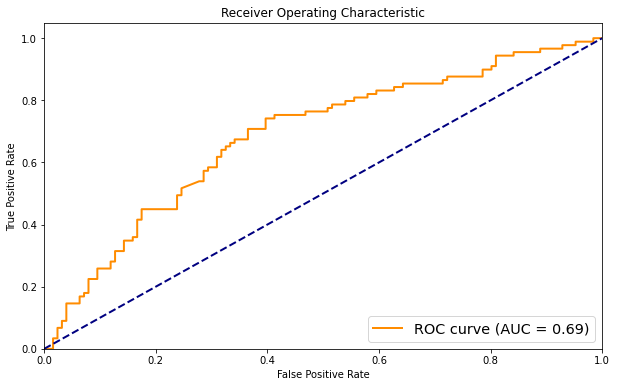

RF


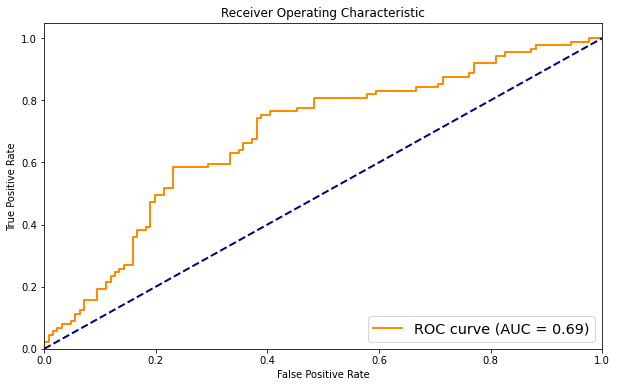

In [64]:
# print test scores
for name, model in fitted_models_Ex2.items():
    print(name)
    predALL_y = model.predict_proba(test_X)[:,1]
    _ = draw_roc_curve(test_y, predALL_y)

In [172]:
for name, model in fitted_models_Ex2.items():
    
    predALL_y = model.predict_proba(test_X)[:,1]
    matrix = pd.DataFrame(confusion_matrix([1 if i == "Sí" else 0 for i in test_y], np.round(predALL_y)),columns=["Actual Positive","Actual Negative"])
    matrix.index = ["Predicted Positive","Predicted Negative"]
    f1 = f1_score([1 if i == "Sí" else 0 for i in test_y], np.round(predALL_y),average="macro")
    print("\nMODEL:",name)
    print("\tConfusion Matrix")
    display(HTML(matrix.to_html()))
    print("\tF1-Score:",f1)


MODEL: SVM
	Confusion Matrix


,Actual Positive,Actual Negative
Predicted Positive,91,35
Predicted Negative,41,48


	F1-Score: 0.6317829457364341

MODEL: RF
	Confusion Matrix


,Actual Positive,Actual Negative
Predicted Positive,97,29
Predicted Negative,45,44


	F1-Score: 0.6335452367790675


As we can see, **I did not get much grater results**.

At first glance, the final Mean cross-validated score is much higher than the previous ones. But, after testing with my test set we can see that the **AUC Scores are lower** than the ones of the Exercice 1: from 0.71 to 0.68.

On the second hand, the confusion matrix are also similar. One thing that surprised me is the amount of False Negatives that we have in the RF model: from 78 in Exercice 1 to 45 with this dataset. That's why the F1-Score of this model has improved: from 0.47 to 0.63. The **F1-Score of the SVM model is the same** in both cases!

# Exercise 3

In order to see which fearures are important for different predictive models we can use ML explainability models. 

Apply ML explainability models to the (i) human risk assessment score, (ii) to the SAVRY baseline model, and (iii) to the best ML model (in terms of performance). 

## Human risk assessment score

The V56_@R1_resum_risc_global_reverse feature is multi-labelled, so **I need to transform the train to a 3-multi-labelled problem**. Therefore, I use the OneVsRestClassifier with the list of models that we've seen in Exercise 1.

In [115]:
from sklearn.multiclass import OneVsRestClassifier

In [116]:
# Transform the categorical variable to numerical-labeled (0, 1 and 2)
train_y_HRisk = train["V56_@R1_resum_risc_global_reverse"].replace('Baixa',0).replace('Moderada',1).replace('Alta',2)
test_y_HRisk = test["V56_@R1_resum_risc_global_reverse"].replace('Baixa',0).replace('Moderada',1).replace('Alta',2)

In [206]:
# Transform the test sets with the binarization of this multi-labeled variable
pre_train_y = preprocessing.label_binarize(train_y_HRisk, classes=[0, 1, 2])
pre_test_y = preprocessing.label_binarize(test_y_HRisk, classes=[0, 1, 2])

I have to modify my pipeline dictionary from Exercice 1 with the new ``OneVsRestClassifier()`` encoder.

In [118]:
# Pipeline dictionary
pipelines_Ex3 = {
    'MLP': make_pipeline(RobustScaler(), OneVsRestClassifier(MLPClassifier(max_iter=500,random_state=1997,
                                                                       early_stopping=True,n_iter_no_change=5))),
    'RF': make_pipeline(RobustScaler(),OneVsRestClassifier(RandomForestClassifier(random_state=1997))),
    'GB': make_pipeline(RobustScaler(),OneVsRestClassifier(GradientBoostingClassifier(random_state=1997))),
    'SVM': make_pipeline(RobustScaler(), OneVsRestClassifier(SVC(random_state=1997,probability=True))),
    'Tree': make_pipeline(RobustScaler(), OneVsRestClassifier(DecisionTreeClassifier(random_state=1997)))
}

The hyperparameteres must be modified as well with ``onevsrestclassifier__estimator__``

In [119]:
# MLP hyperparameters
MLP_hyperparameters = {
    'onevsrestclassifier__estimator__activation': ['relu','tanh',"logistic"],
    'onevsrestclassifier__estimator__solver':['adam',"lbfgs"],
    'onevsrestclassifier__estimator__hidden_layer_sizes': [(200,200,200,200,200,200),(150,150,150,150,150),(120,120,120,120,120)],
    'onevsrestclassifier__estimator__alpha': [0.0001,0.001]
}

# Random Forest hyperparameters
rf_hyperparameters = {
    'onevsrestclassifier__estimator__n_estimators': [50,100,200,250],
    'onevsrestclassifier__estimator__max_features': ['auto'],
    'onevsrestclassifier__estimator__max_depth':[1,5,10],
    'onevsrestclassifier__estimator__min_samples_leaf': [4,5,10],
    'onevsrestclassifier__estimator__min_samples_split': [10,15,20],
    'onevsrestclassifier__estimator__bootstrap': [True, False]
}

# Boosted Tree hyperparameters
gb_hyperparameters = {
    'onevsrestclassifier__estimator__n_estimators': [1,2,50,100,200],
    'onevsrestclassifier__estimator__learning_rate': [0.05,0.1,0.2],
    'onevsrestclassifier__estimator__max_depth':[1.,3,5,20.,30.],
    'onevsrestclassifier__estimator__min_samples_split':[0.1,0.5,1.],
    'onevsrestclassifier__estimator__min_samples_leaf':[0.1,0.5],
    'onevsrestclassifier__estimator__max_features':[1,10,40,100]
}

# SVM hyperparameters
svm_hyperparameters = {'onevsrestclassifier__estimator__C': [0.1, 1, 10], 
          'onevsrestclassifier__estimator__gamma': [1, 0.1, 0.01,"auto"],
          'onevsrestclassifier__estimator__kernel': ['rbf']}

# Decision tree hyperparameters
tree_hyperparameters = {'onevsrestclassifier__estimator__min_samples_leaf':[5,10,15,20],
                        'onevsrestclassifier__estimator__max_features':[5,10,15],
                        'onevsrestclassifier__estimator__criterion': ['gini', 'entropy'],
                        'onevsrestclassifier__estimator__max_depth':[2,4,6,8,10,12]}

# Create hyperparameters dictionary
hyperparametersEx3 = {'MLP': MLP_hyperparameters,
                  'RF': rf_hyperparameters,
                  'GB': gb_hyperparameters,
                  'SVM':svm_hyperparameters,
                  'Tree':tree_hyperparameters}

In [207]:
# Fitting funtion. This lasts ~4 minutes!!
fitted_models_Ex3 = fit(pipelines_Ex3,hyperparametersEx3,train_X,pre_train_y)


MLP has been fitted
	Best model param: {'onevsrestclassifier__estimator__activation': 'tanh', 'onevsrestclassifier__estimator__alpha': 0.0001, 'onevsrestclassifier__estimator__hidden_layer_sizes': (200, 200, 200, 200, 200, 200), 'onevsrestclassifier__estimator__solver': 'adam'}

RF has been fitted
	Best model param: {'onevsrestclassifier__estimator__bootstrap': True, 'onevsrestclassifier__estimator__max_depth': 5, 'onevsrestclassifier__estimator__max_features': 'auto', 'onevsrestclassifier__estimator__min_samples_leaf': 5, 'onevsrestclassifier__estimator__min_samples_split': 10, 'onevsrestclassifier__estimator__n_estimators': 50}

GB has been fitted
	Best model param: {'onevsrestclassifier__estimator__learning_rate': 0.05, 'onevsrestclassifier__estimator__max_depth': 1.0, 'onevsrestclassifier__estimator__max_features': 10, 'onevsrestclassifier__estimator__min_samples_leaf': 0.1, 'onevsrestclassifier__estimator__min_samples_split': 0.1, 'onevsrestclassifier__estimator__n_estimators': 1

In [121]:
# Display best_score_ for each fitted model
for name,model in fitted_models_Ex3.items():
    print(name, "Score: ", model.best_score_)

MLP Score:  0.8035188513583428
RF Score:  0.8257292051483596
GB Score:  0.818664319292703
SVM Score:  0.8124263263016326
Tree Score:  0.7750155051807437


In order to **plot the ROC Curves of a multi-labeled model** I need to modify some code of the original-given function.

In [122]:
from sklearn.metrics import accuracy_score
from itertools import cycle

In [123]:
def plot_multi_class_ROC_Curve(fitted_models):    
    # print test scores
    n_classes = pre_test_y.shape[1]
    for name, model in fitted_models.items():
        print(name)
        predALL_y = model.predict_proba(test_X)
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(pre_test_y[:, i], predALL_y[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(pre_test_y.ravel(), predALL_y.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        lw = 3
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot all ROC curves
        plt.figure()
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(i, roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Some extension of Receiver operating characteristic to multi-class')
        plt.legend(loc="lower right")
        plt.show()

MLP


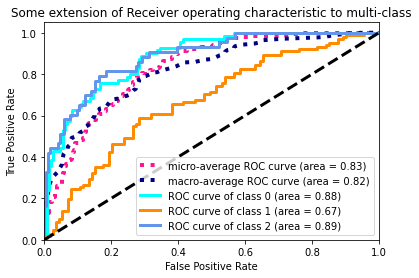

RF


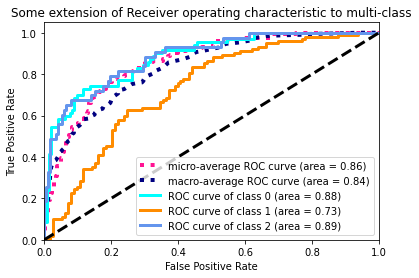

GB


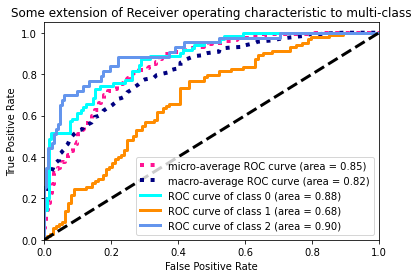

SVM


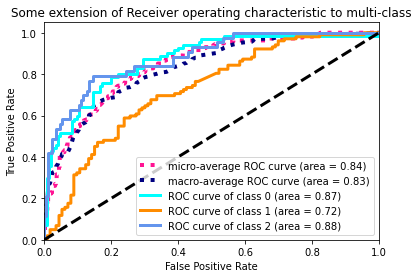

Tree


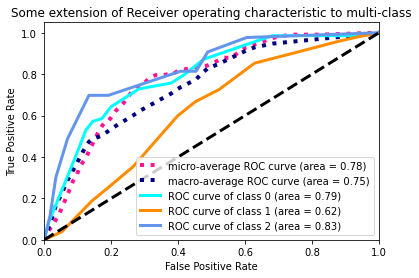

In [124]:
plot_multi_class_ROC_Curve(fitted_models_Ex3)

This plot allows me to **see the performance of each model with each of the 3 classes separately** but also with an average of the micro and macro ROC Curves. As we can see, the best model in terms of accuracy is the Random Forest one!

# SAVRY baseline model

The SAVRY Score is a **Logistic Regression** problem!

In [190]:
train_y_SAVRY = train["V60_SAVRY_total_score"]
test_y_SAVRY = test["V60_SAVRY_total_score"]

In [191]:
LGSavry = LogisticRegression(solver='liblinear')

In [192]:
#Fit the model using the training data
LGSavry.fit(train_X,train_y_SAVRY)

LogisticRegression(solver='liblinear')

In [185]:
LGSavry.score(test_X,test_y_SAVRY)

0.8837209302325582

We can see that we got an accuracy of 88% which is **in the line of the previous models**. What's interesting in this model is the feature importance that we are going to see below.

 _In Exercice 1 I've already applied ML explainability to the best model trained_

### Questions

1. Which are the top ten most important features of each model?

### Human Risk Assessment

In [175]:
feat_impts = [] 
for i in RFEx3['onevsrestclassifier'].estimators_:
    feat_impts.append(i.feature_importances_)

mean = np.mean(feat_impts, axis=0)
pd.DataFrame(mean*10,index=test_X.columns,columns=["Importance"]).sort_values("Importance",ascending=False)[:10]

,Importance
V81_@17_actitud_negatives_Baix,0.668935
V75_@11_delinquencia_grup_iguals_Alt,0.417638
V75_@11_delinquencia_grup_iguals_Baix,0.404949
V84_@20_problemes_maneig_enuig_Alt,0.334322
V87_@23_baixa_colaboracio_intervencions_Baix,0.289612
V81_@17_actitud_negatives_Alt,0.284866
V85_@21_baix_nivell_empatia_remordiment_Baix,0.279925
V82_@18_assumpcio_riscos_impulsivitat_Alt,0.272497
V81_@17_actitud_negatives_Moderat,0.267366
V20_nombre_antecedents,0.233675


As we can see below, the most important feature of the RF model for the human risk assessment category is **if the individual had a lower number of negative attitudes**. In second and third place, the type of delinquency in the peer group. 

Note that the number of "records" (antecedents) is in 10th place. In the first RF model of Exercice 1, **it was in first place**.

### SAVRY Scores

With Logistic Regression we have to look at the **coefficients**, thanks to the ``.coef_()`` method. 

In [203]:
mean = np.mean(LGSavry.coef_, axis=0)
pd.DataFrame(mean*10,index=test_X.columns,columns=["Importance"]).sort_values("Importance",ascending=False)[:10]

,Importance
V67_@3_inici_precoç_violencia_Baix,0.463913
V15_fet_agrupat_Contra les persones,0.281962
V72_@8_delinquencia_pares_Baix,0.134791
V78_@14_escassa_habilitat_pares_educar_Moderat,0.078180
V65_@1_violencia_previa_Alt,0.052470
V83_@19_problemes_consum_toxics_Moderat,0.032564
V87_@23_baixa_colaboracio_intervencions_Alt,-0.022292
V82_@18_assumpcio_riscos_impulsivitat_Moderat,-0.079641
V85_@21_baix_nivell_empatia_remordiment_Baix,-0.115688
V73_@9_separacio_precoç_pares_Alt,-0.123124


We can see below a whole new order than the previous model. I find it interesting that in first place we have the **early initiation of violence** in grade low, which in my opinion is a critical feature that I've not seen in the top-10 most importance features of previous models.

2. Look at the features thar are important for the best ML model after the application of the equalized base rates (EBR) mitigation stratgey. Is there any difference?

> Let me gather again the RF model from Exercice 2 with EBR applied on it. 

In [205]:
RFImportance=list(zip(fitted_models_Ex2['RF'].best_estimator_.named_steps['randomforestclassifier'].feature_importances_,train_X))
RFImportance.sort(reverse=True)
for i in range(10):
    print(RFImportance[i])

(0.06507047546896488, 'V1_sexe_Home')
(0.0621491511988939, 'V1_sexe_Dona')
(0.046007748109057445, 'V8_edat_fet')
(0.03386891238584831, 'V20_nombre_antecedents')
(0.030220219433157714, 'V89_@P1_impicacio_prosocial_Absent')
(0.027298167867335715, 'V79_@15_manca_suport_personal_social_Alt')
(0.02481652261399749, 'V80_@16_entorn_marginal_Baix')
(0.02053105598359567, 'V89_@P1_impicacio_prosocial_Present')
(0.015636402757076145, 'V80_@16_entorn_marginal_Moderat')
(0.014937967523884516, 'V81_@17_actitud_negatives_Baix')


Surprisingly, we see that the **Gender feature is the most important one!**

On third place we have how old is the offender in the moment of the commission of the crime, which is a critical feature that again I've not seen on other models. Instead, the **community disorganization level is present in both** EBR RF model and the "virgin" RF model.

In conclusion, each model has it's own feature importance and this is due to a long list of causes: the type of the ML algorithm, the amount of samples (we have seen it in the EBR RF model)... After this exercises I still think that recividism probabilty should not be computed only with ML models but with human experts **plus the help of ML**.